<a href="https://colab.research.google.com/github/itzahs/SSL-for-RS/blob/main/1_GetData%26Software_SSL4RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 **Semi-Supervised Learning for Remote Sensing (SSL4RS) Workshop** 🛰️

## 📂 Section 1 - Get Data & Software: Dataset Download & Augmentation
## 🛠️ Section 2 - Train Model: Implementing FixMatch Algorithm with PyTorch
## 📊 Section 3 - Model Evaluation: Analyzing Accuracy & Computational Cost from Log Files
## 📈 Section 4 - Model Inference: Inference with Trained Models & Confusion Matrix


### 📚 Setting Up the Working Folder & Importing Required Packages


In [2]:
# Standard library imports (Built-in modules)
import os
import sys
import zipfile

# Third-party library imports
import numpy as np
import random
import urllib.request
from PIL import Image, TiffImagePlugin
import matplotlib.pyplot as plt
import tempfile

# PyTorch imports
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [3]:
# Local modules
from google.colab import drive

# Mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Create working folder
folder_name = "SSL4RS"
path_to_folder = "/content/drive/MyDrive/" + folder_name

if not os.path.exists(path_to_folder):
    os.makedirs(path_to_folder)
    print(F"Folder '{folder_name}' has been created successfully.")
else:
    print(F"Folder '{folder_name}' already exists.")

# Set working folder as default
%cd "/content/drive/MyDrive/SSL4RS"

Folder 'SSL4RS' has been created successfully.
/content/drive/MyDrive/SSL4RS


### 📦 Retrieve Software: Classification-SemiCLS


In [4]:
# Clone the repository without downloading large files
!git clone --filter=blob:limit=10m https://github.com/TencentYoutuResearch/Classification-SemiCLS.git

Cloning into 'Classification-SemiCLS'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 112 (delta 32), reused 97 (delta 20), pack-reused 0
Receiving objects: 100% (112/112), 78.57 KiB | 2.81 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Error downloading object: pretrained_models/moco_inat_ep800.pth.tar (f79c30a): Smudge error: Error downloading pretrained_models/moco_inat_ep800.pth.tar (f79c30a101a2a00a345be46f1d61c20b4ce313ca46f9fd92d9deeb2c03524d10): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/drive/MyDrive/SSL4RS/Classification-SemiCLS/.git/lfs/logs/20230910T191420.966931021.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: pretrained_models/moco_inat_ep800.pth.tar: smudge filter lfs failed
Y

In [5]:
# Append the parent directory (Classification-SemiCLS) to sys.path:
# The list in Python that specifies the directories for modules and packages to import.
sys.path.append('/content/drive/MyDrive/SSL4RS/Classification-SemiCLS')

In [6]:
# Set working folder as default
%cd "/content/drive/MyDrive/SSL4RS/Classification-SemiCLS"

/content/drive/MyDrive/SSL4RS/Classification-SemiCLS


### 🌐 Download UCM Dataset & Create Train/Test Files


In [7]:
# URL where data is stored
data_url = 'http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip'
zip_file_path = 'UCMerced_LandUse.zip'
data_dir_path = '/content/drive/MyDrive/SSL4RS/Classification-SemiCLS/data/UCM'

# Downloading the UCM dataset
if not os.path.exists(zip_file_path):
    print(f"Downloading {data_url}...")
    urllib.request.urlretrieve(data_url, zip_file_path)

# Unzipping the UCM dataset
if not os.path.exists(data_dir_path):
    print(f"Unzipping {zip_file_path}...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('/content/drive/MyDrive/SSL4RS/Classification-SemiCLS/data')
        # Rename the extracted folder to 'UCM'
        os.rename('/content/drive/MyDrive/SSL4RS/Classification-SemiCLS/data/UCMerced_LandUse', data_dir_path)

# Checking that the data was correctly extracted
!ls '/content/drive/MyDrive/SSL4RS/Classification-SemiCLS/data'


Unzipping UCMerced_LandUse.zip...
UCM


In [8]:
# Define the base path for the image folders
root_dir = './data/UCM/Images'

# Get subfolders path
folders = sorted([f.path for f in os.scandir(root_dir) if f.is_dir()])

# Create dictionary where each subfolder has a value
classes_dict = {}
for i, folder in enumerate(folders):
    folder_name = os.path.basename(folder)
    classes_dict[folder_name] = i
print(classes_dict)

# From the dictionary get the classes as list
classes = list(classes_dict.keys())
print(classes)

{'agricultural': 0, 'airplane': 1, 'baseballdiamond': 2, 'beach': 3, 'buildings': 4, 'chaparral': 5, 'denseresidential': 6, 'forest': 7, 'freeway': 8, 'golfcourse': 9, 'harbor': 10, 'intersection': 11, 'mediumresidential': 12, 'mobilehomepark': 13, 'overpass': 14, 'parkinglot': 15, 'river': 16, 'runway': 17, 'sparseresidential': 18, 'storagetanks': 19, 'tenniscourt': 20}
['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


In [9]:
# Define paths for train and test files
train_file = open("./data/UCM/Images/UCM_train.txt", "w")
test_file = open("./data/UCM/Images/UCM_test.txt", "w")

# Define split percentage
split = 0.5

# Define seed for random shuffle
seed = 123

# Loop through folders
for foldername in os.listdir(root_dir):
    if not os.path.isdir(os.path.join(root_dir, foldername)):
        continue  # skip files
    # Get list of files on each folder and class
    class_id = classes_dict[foldername]
    file_list = os.listdir(os.path.join(root_dir, foldername))
    # Shuffle the file list with a fixed seed for reproducibility
    random.seed(seed)
    random.shuffle(file_list)
    # Get number of files for each folder and create the split
    num_files = len(file_list)
    train_count = int(num_files * split)
    test_count = num_files - train_count
    # Write the files
    for filename in file_list[:train_count]:
        path = os.path.join(root_dir, foldername, filename)
        train_file.write(f"{path} {class_id}\n")
    for filename in file_list[train_count:]:
        path = os.path.join(root_dir, foldername, filename)
        test_file.write(f"{path} {class_id}\n")

# Close files
train_file.close()
test_file.close()

In [10]:
train_file = open("./data/UCM/Images/UCM_train.txt", "r")
test_file = open("./data/UCM/Images/UCM_test.txt", "r")

# Initialize a counter for each class at 0
train_counts = {class_: 0 for class_ in classes}
test_counts = {class_: 0 for class_ in classes}

# For every line that contains the class name, add 1
for line in train_file:
    image_path, class_int = line.strip().split()
    class_ = image_path.split("/")[-2]
    train_counts[class_] += 1

for line in test_file:
    image_path, class_int = line.strip().split()
    class_ = image_path.split("/")[-2]
    test_counts[class_] += 1

train_file.close()
test_file.close()

# Print how many images are in each txt file
print("Train Counts:")
for class_ in classes:
    print(f"{class_}: {train_counts[class_]}")

print("\nTest Counts:")
for class_ in classes:
    print(f"{class_}: {test_counts[class_]}")


Train Counts:
agricultural: 50
airplane: 50
baseballdiamond: 50
beach: 50
buildings: 50
chaparral: 50
denseresidential: 50
forest: 50
freeway: 50
golfcourse: 50
harbor: 50
intersection: 50
mediumresidential: 50
mobilehomepark: 50
overpass: 50
parkinglot: 50
river: 50
runway: 50
sparseresidential: 50
storagetanks: 50
tenniscourt: 50

Test Counts:
agricultural: 50
airplane: 50
baseballdiamond: 50
beach: 50
buildings: 50
chaparral: 50
denseresidential: 50
forest: 50
freeway: 50
golfcourse: 50
harbor: 50
intersection: 50
mediumresidential: 50
mobilehomepark: 50
overpass: 50
parkinglot: 50
river: 50
runway: 50
sparseresidential: 50
storagetanks: 50
tenniscourt: 50


### 🔨 Data Augmentation and Transformations

In this section, we will perform transformations on our dataset to enhance its diversity and prepare it for training. By following these steps, we aim to enrich our dataset and improve the model's robustness during training.


#### **1. Baseline Dataset**
Create an instance of the dataset without applying any transformations.

#### **2. Weak Transformations**
Generate a dataset with weak transformations, including `RandomHorizontalFlip` and `CenterCrop`.

#### **3. Strong Augmentation Strategy 1**
Apply a strong augmentation strategy using `Randaugment`.

#### **4. Strong Augmentation Strategy 2**
Implement another strong augmentation strategy, incorporating `color jittering` and `grayscaling`.



In [7]:
# Get the MyDataset class from the Classification-SemiCLS software
from dataset.MyDataset import MyDataset

# class MyDataset(Dataset):

  # Interface provided for customized data sets

  # names_file：a txt file, each line in the form of "image_path label"

  # transform: transform pipline for mydataset


### Call dataset with no transformations

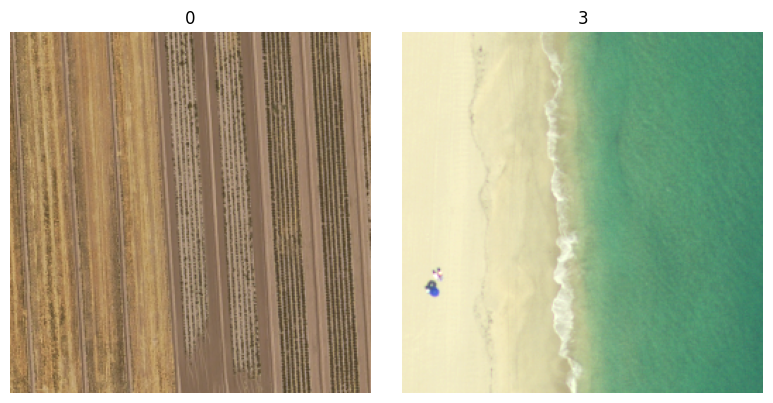

In [12]:
# Create an instance of the dataset with no transformations
names_file = './data/UCM/Images/UCM_train.txt'
dataset = MyDataset(names_file, transform=None)

# Access individual images and their labels by indexing the dataset object
image1, label1 = dataset[0]
image2, label2 = dataset[150]

# Create a single plot with horizontally stacked images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display the first image
axes[0].imshow(image1)
axes[0].set_title(label1)
axes[0].axis('off')

# Display the second image
axes[1].imshow(image2)
axes[1].set_title(label2)
axes[1].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Apply weak augmentation strategy

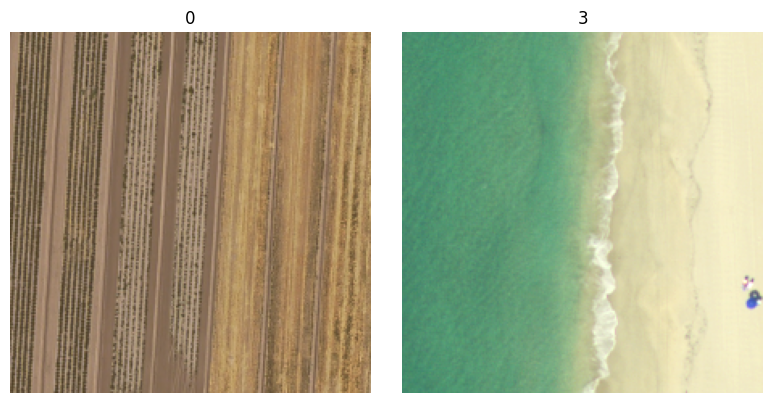

In [13]:
# Create an instance of the dataset with weak transformation
names_file = './data/UCM/Images/UCM_train.txt'
transform_w = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor()
    #skip normalization or original RGB colors will not display properly
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
dataset_w = MyDataset(names_file, transform=transform_w)

# Access individual images and their labels by indexing the dataset object
image_w1, label_w1 = dataset_w[0]
image_w2, label_w2 = dataset_w[150]

# Get the tensors of shape [3, 224, 224] back to PIL.TiffImage format
image_array1 = image_w1.cpu().numpy().transpose(1, 2, 0)
image_pil1 = Image.fromarray(np.uint8(image_array1 * 255))

image_array2 = image_w2.cpu().numpy().transpose(1, 2, 0)
image_pil2 = Image.fromarray(np.uint8(image_array2 * 255))

# Create a subplot grid with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display the first weakly transformed image
axes[0].imshow(image_pil1)
axes[0].set_title(label_w1)
axes[0].axis('off')

# Display the second weakly transformed image
axes[1].imshow(image_pil2)
axes[1].set_title(label_w2)
axes[1].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Apply strong augmentation 1 strategy with randaugment

In [8]:
# Get the MyDataset class
from dataset.transforms.randaugment import RandAugmentMC

# RandAugmentMC(n,m)
    # choose n augmentation for the pool
    # and repeat m times

# AutoContrast, Brightness, Color, Contrast, Cutout, CutoutAbs, Equalize, Identity, Invert,
# Posterize, Rotate, Sharpness, ShearX, ShearY, Solarize, SolarizeAdd, TranslateX, and TranslateY.


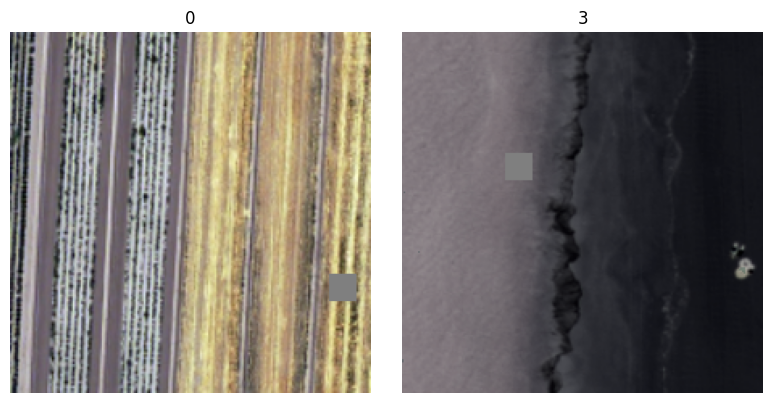

In [13]:
# Create an instance of the dataset with the different transformation (transform_s2)
names_file = './data/UCM/Images/UCM_train.txt'

transform_s1 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=224, scale=(0.2, 1.0)),
    transforms.Lambda(lambda img: RandAugmentMC(n=2, m=10)(img)),   # Use RandAugmentMC directly with desired parameters
    transforms.ToTensor(),
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

dataset_s1 = MyDataset(names_file, transform=transform_s1)

# Access individual images and their labels by indexing the dataset object
image_s1_1, label_s1_1 = dataset_s1[0]
image_s1_2, label_s1_2 = dataset_s1[150]

# Get the tensors of shape [3, 224, 224] back to PIL.TiffImage format for differently transformed images
image_array_s1_1 = image_s1_1.cpu().numpy().transpose(1, 2, 0)
image_pil_s1_1 = Image.fromarray(np.uint8(image_array_s1_1 * 255))

image_array_s1_2 = image_s1_2.cpu().numpy().transpose(1, 2, 0)
image_pil_s1_2 = Image.fromarray(np.uint8(image_array_s1_2 * 255))

# Create a subplot grid with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display the first differently transformed image
axes[0].imshow(image_pil_s1_1)
axes[0].set_title(label_s1_1)
axes[0].axis('off')

# Display the second differently transformed image
axes[1].imshow(image_pil_s1_2)
axes[1].set_title(label_s1_2)
axes[1].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Apply strong augmentation 2 strategy with color jittering and grayscalling

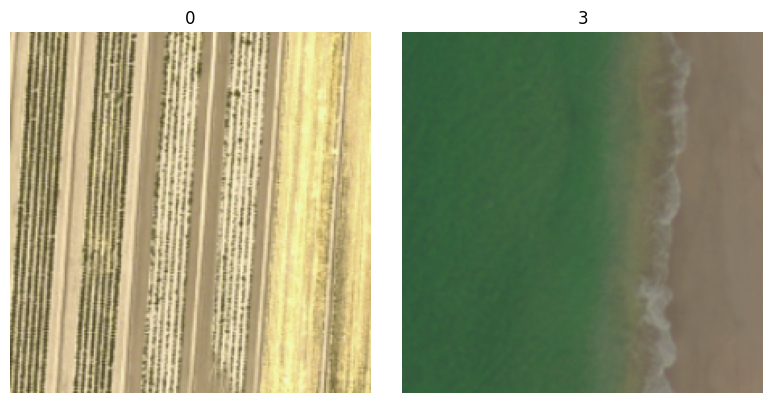

In [16]:
# Create an instance of the dataset with strong transformation
names_file = './data/UCM/Images/UCM_train.txt'
transform_s2 = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()
])

dataset_s2 = MyDataset(names_file, transform=transform_s2)

# Access individual images and their labels by indexing the dataset object
image_s2_1, label_s2_1 = dataset_s2[0]
image_s2_2, label_s2_2 = dataset_s2[150]

# Get the tensors of shape [3, 224, 224] back to PIL.TiffImage format for differently transformed images
image_array_s2_1 = image_s2_1.cpu().numpy().transpose(1, 2, 0)
image_pil_s2_1 = Image.fromarray(np.uint8(image_array_s2_1 * 255))

image_array_s2_2 = image_s2_2.cpu().numpy().transpose(1, 2, 0)
image_pil_s2_2 = Image.fromarray(np.uint8(image_array_s2_2 * 255))

# Create a subplot grid with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display the first differently transformed image
axes[0].imshow(image_pil_s2_1)
axes[0].set_title(label_s2_1)
axes[0].axis('off')

# Display the second differently transformed image
axes[1].imshow(image_pil_s2_2)
axes[1].set_title(label_s2_2)
axes[1].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()